### Imports

In [1]:
import scipy.io
import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import copy

### Bases de données

In [2]:
alpha = scipy.io.loadmat('binaryalphadigs.mat') 

In [3]:
from keras.datasets import mnist
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

def digits(digit):
  '''
  Prend en argument un chiffre digit et retourne les images MNIST 28x28 correspondant
  à ce label
  '''
  digits=[]
  for i in range(len(Xtrain)):
    if ytrain[i] == digit:
      digits.append(Xtrain[i])
  return digits

11501568/11490434 [==============================] - 0s 0us/step


### Fonctions auxiliaires

In [4]:
def sigmoid(X):
  '''
  Prend en argument un vecteur X et retourne la fonction sigmoid associée à ce vecteur
  '''
  return 1 / (1 + np.exp(-X))

def softmax(X,w,b):
  '''
  Prend en argument un vecteur X et retourne la fonction softmax associée à ce vecteur
  '''
  z=np.dot(X,w)+b
  return np.exp(z)/np.transpose([np.sum(np.exp(z),axis=1)])

def mini_batches(X,batch_size):
  '''
  Prend en argument une liste X et la sépare en une liste de batch de tailles resepectives batch_size 
  '''
  data_size=X.shape[0]
  batch = [] 
  nb_batch = data_size // batch_size
  reste=data_size % batch_size
  
  for i in range(nb_batch): 
    mini_batch = X[i * batch_size:(i + 1)*batch_size] 
    batch.append([x.flatten() for x in mini_batch])
  if reste != 0:
    mini_batch=X[data_size-reste:data_size]
    mini_batch=np.append(mini_batch,X[0:batch_size-reste],axis=0)
    batch.append([x.flatten() for x in mini_batch])
  return batch

### Construction d'un RBM et test sur AlphaDigit

In [5]:
def lire_alpha_digit(indice_caractere,num):
  '''
  Renvoie les images liées à un nombre d'indice de caractère indice_caractere
  '''
  nombre=alpha["dat"][indice_caractere,num]
  return nombre

class RBM():
  def __init__(self,n_v, n_h):
    self.a=[0 for i in range(n_v)]
    self.b=[0 for i in range(n_h)]
    self.w=np.random.normal(0,0.1,(n_v,n_h))

  def entree_sortie_RBM(self,V):
     sig=sigmoid(np.dot(V,self.w)+self.b)
     Hs=np.random.binomial(1, sig, size=sig.shape)
     return np.array(sig),Hs
     
  def sortie_entree_RBM(self,H):
     q=sigmoid(np.dot(H,np.transpose(self.w))+self.a)
     Vs=np.random.binomial(1, q, size=q.shape)
     return np.array(q),Vs
  
  def train_RBM(self,X,batch_size,epochs,learning_rate):
    for j in range(epochs):
      batches=mini_batches(X,batch_size)
      loss=0
      somme=0
      for i in batches:
        V=np.array(i)
        p,Hs=RBM.entree_sortie_RBM(self,V)
        q1,V1= RBM.sortie_entree_RBM(self,Hs)
        p1,H1= RBM.entree_sortie_RBM(self,V1)
        dw= (1/batch_size)*(np.dot(np.transpose(V),p)-np.dot(np.transpose(V1),p1))
        da= (1/batch_size)* np.sum(V-V1,axis=0)
        db= (1/batch_size)* np.sum(p-p1,axis=0)
        self.w+=learning_rate*dw
        self.a+=learning_rate*da
        self.b+=learning_rate*db
        loss+=np.mean(np.square(V1-V))
        somme+=1
      print("Epoch " + str(j)+ " Quadratic loss = " + str(loss/somme))
    return str(loss/somme)

In [6]:
def generer_image_RBM(X,n_images,rbm,batch_size,epochs,learning_rate,iter_gibbs):
  rbm.train_RBM(X,batch_size,epochs,learning_rate)
  L,l=np.shape(X[0])
  for i in range(n_images):
    v=np.random.randint(2,size=L*l)
    for k in range(iter_gibbs):
      ph,h=rbm.entree_sortie_RBM(v)
      pv,v=rbm.sortie_entree_RBM(h)

      
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(L,l))
    plt.subplot(221)
    plt.imshow(np.array(X[i]).reshape(L,l))

    plt.subplot(222)
    plt.imshow(np.array(v).reshape((L,l)))
    plt.show()

### Comparaison entre les vraies images et les images générées par le RBM

Epoch 0 Quadratic loss = 0.34732142857142856
Epoch 1 Quadratic loss = 0.29308035714285713
Epoch 2 Quadratic loss = 0.27046130952380953
Epoch 3 Quadratic loss = 0.2421875
Epoch 4 Quadratic loss = 0.22998511904761904
Epoch 5 Quadratic loss = 0.21197916666666666
Epoch 6 Quadratic loss = 0.20089285714285718
Epoch 7 Quadratic loss = 0.18571428571428572
Epoch 8 Quadratic loss = 0.17901785714285715
Epoch 9 Quadratic loss = 0.1741815476190476
Epoch 10 Quadratic loss = 0.16659226190476192
Epoch 11 Quadratic loss = 0.16086309523809522
Epoch 12 Quadratic loss = 0.15550595238095236
Epoch 13 Quadratic loss = 0.14769345238095238
Epoch 14 Quadratic loss = 0.1463541666666667
Epoch 15 Quadratic loss = 0.14092261904761905
Epoch 16 Quadratic loss = 0.1348214285714286
Epoch 17 Quadratic loss = 0.13541666666666669
Epoch 18 Quadratic loss = 0.12961309523809522
Epoch 19 Quadratic loss = 0.12566964285714285
Epoch 20 Quadratic loss = 0.12232142857142857
Epoch 21 Quadratic loss = 0.11763392857142858
Epoch 22 Qu

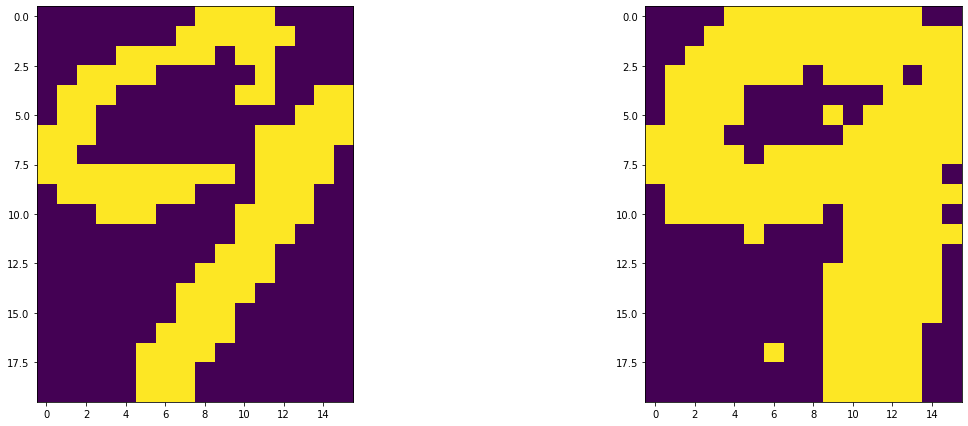

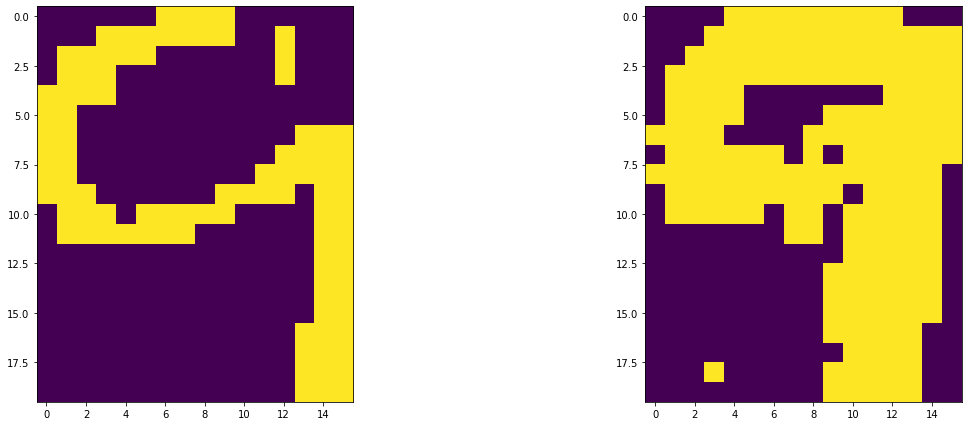

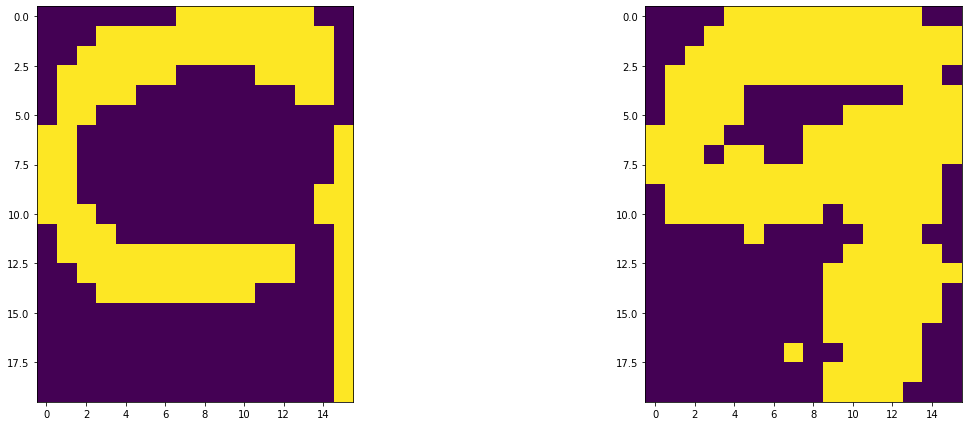

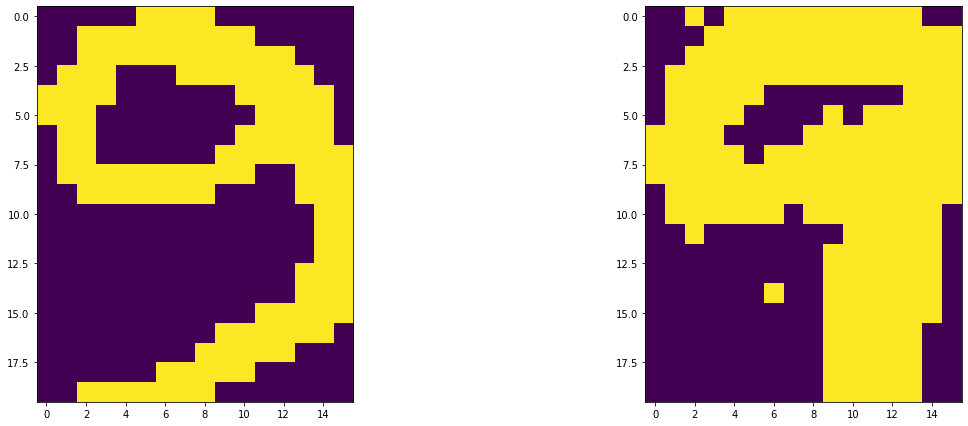

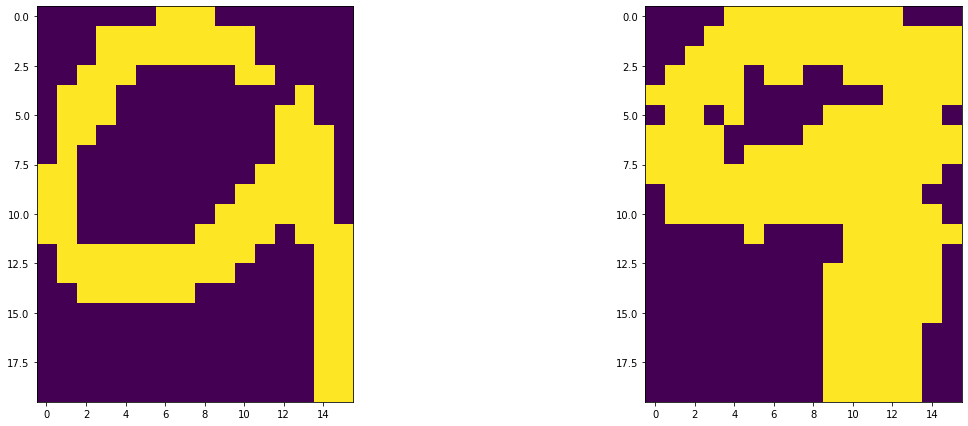

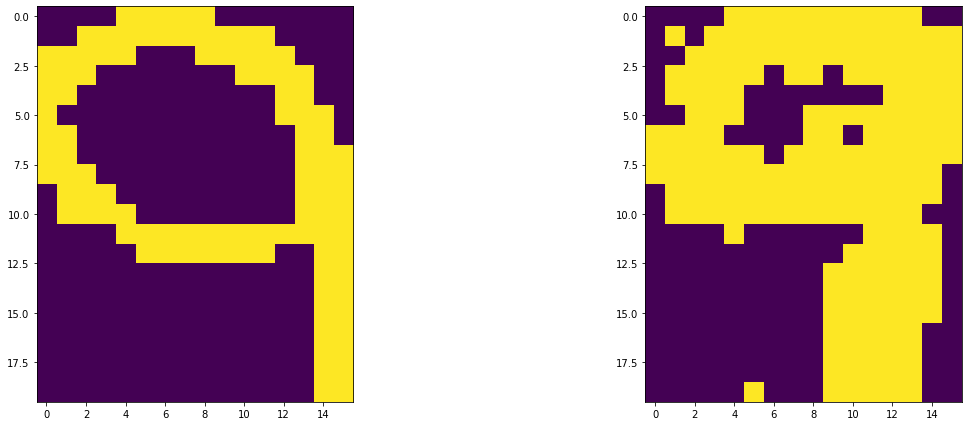

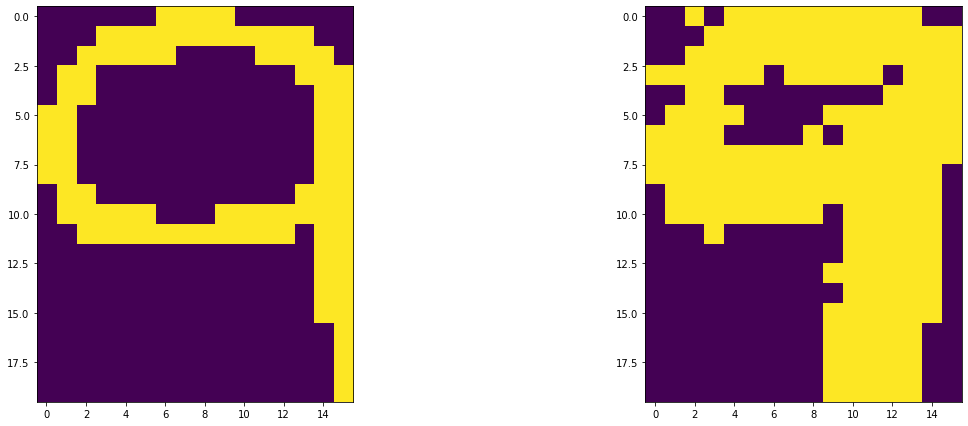

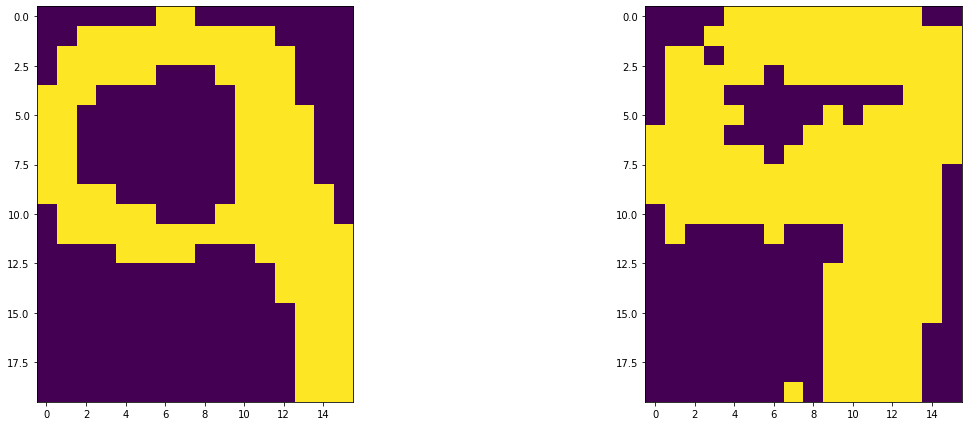

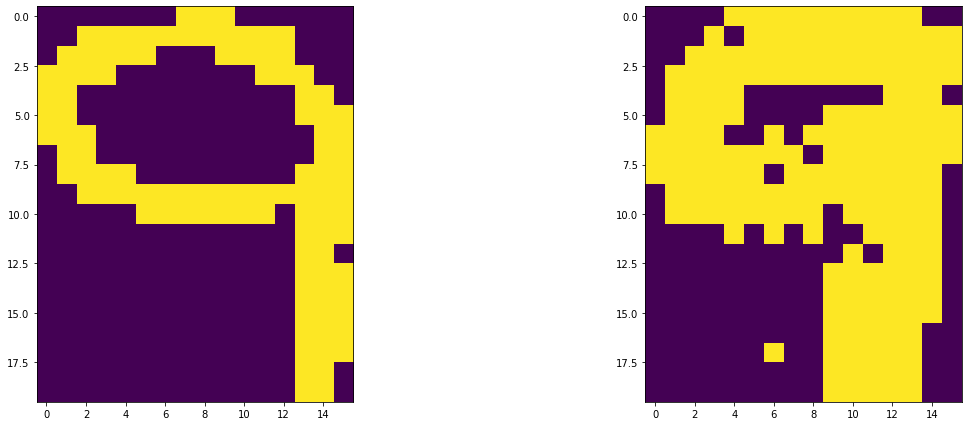

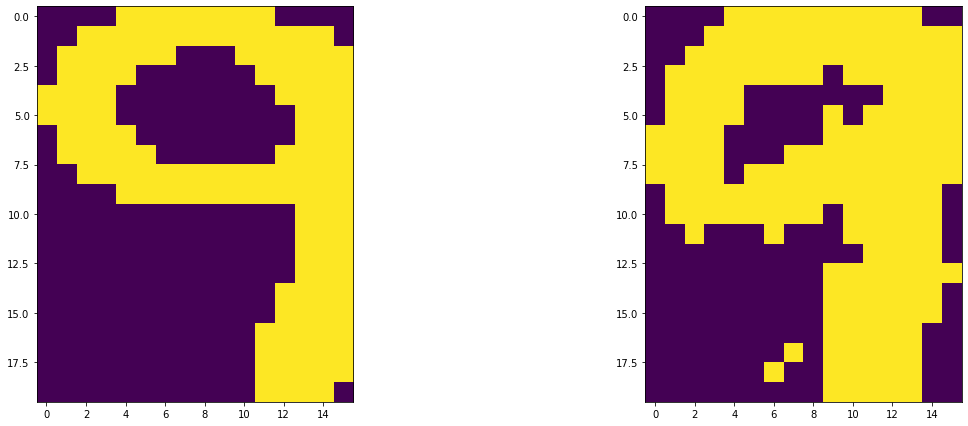

In [7]:
def resultats_RBM(n_images,indices_caractere,arc,batch_size,epochs,learning_rate,iter_gibbs):
  '''
  Prend en argument le nombre d'images à générer, l'indice du caractère que l'on veut génerer, 
  le nombre d'unités cachées, la taille du batch,
  le nombre d'epochs, le learning rate et le nombre d'itérations de Gibbs
  Renvoie les images générées ainsi que des images de la base de données et les résultats de l'entraînement
  '''
  X=np.concatenate( [alpha["dat"][i] for i in [indices_caractere]])
  #np.random.shuffle(X)
  L,l=np.shape(X[0])
  rbm=RBM(L*l,arc)
  final_loss=rbm.train_RBM(X,batch_size,epochs,learning_rate)
  generer_image_RBM(X,n_images,rbm,batch_size,epochs,learning_rate,iter_gibbs)

resultats_RBM(10,9,100,6,100,0.1,100)

### Optimisation selon le learning rate et le nombre d'unités arc
On cherche ici à trouver les hyperparamètres optimales pour le RBM appliqué à AlphaDigit. 

In [8]:
def optimisation_lr(n_images,indices_caractere,arc,batch_size,epochs,learning_rates,iter_gibbs):
  final_loss=[]
  for i in range(len(learning_rates)):
    X=np.concatenate( [alpha["dat"][i] for i in [indices_caractere]])
    L,l=np.shape(X[0])
    rbm=RBM(L*l,arc)
    final_loss.append(rbm.train_RBM(X,batch_size,epochs,learning_rates[i]))
  return final_loss

def optimisation_units(n_images,indices_caractere,arc,batch_size,epochs,learning_rate,iter_gibbs):
  final_loss=[]
  for i in range(len(arc)):
    X=np.concatenate( [alpha["dat"][i] for i in [indices_caractere]])
    L,l=np.shape(X[0])
    rbm=RBM(L*l,arc[i])
    final_loss.append(rbm.train_RBM(X,batch_size,epochs,learning_rate))
  print(final_loss)
  return final_loss

optimisation_units(10,25,[2,5,10,50,100,200,400,600,800,1000,4000],6,100,0.01,10)

Epoch 0 Quadratic loss = 0.497172619047619
Epoch 1 Quadratic loss = 0.4921875
Epoch 2 Quadratic loss = 0.4892113095238095
Epoch 3 Quadratic loss = 0.4797619047619048
Epoch 4 Quadratic loss = 0.4708333333333333
Epoch 5 Quadratic loss = 0.46145833333333336
Epoch 6 Quadratic loss = 0.455952380952381
Epoch 7 Quadratic loss = 0.4501488095238096
Epoch 8 Quadratic loss = 0.43742559523809527
Epoch 9 Quadratic loss = 0.4342261904761905
Epoch 10 Quadratic loss = 0.4379464285714286
Epoch 11 Quadratic loss = 0.42418154761904764
Epoch 12 Quadratic loss = 0.42380952380952375
Epoch 13 Quadratic loss = 0.41599702380952375
Epoch 14 Quadratic loss = 0.40438988095238093
Epoch 15 Quadratic loss = 0.4084077380952381
Epoch 16 Quadratic loss = 0.4083333333333333
Epoch 17 Quadratic loss = 0.40148809523809526
Epoch 18 Quadratic loss = 0.39136904761904756
Epoch 19 Quadratic loss = 0.390625
Epoch 20 Quadratic loss = 0.3959821428571429
Epoch 21 Quadratic loss = 0.40007440476190476
Epoch 22 Quadratic loss = 0.3834

['0.32864583333333336',
 '0.30892857142857144',
 '0.28467261904761904',
 '0.1886160714285714',
 '0.15297619047619046',
 '0.10952380952380951',
 '0.07418154761904762',
 '0.05758928571428571',
 '0.045163690476190475',
 '0.041369047619047625',
 '0.011904761904761904']

On affiche les valeurs de loss pour les différents paramètres testés. 

Epoch 0 Quadratic loss = 0.49672619047619043
Epoch 1 Quadratic loss = 0.4914434523809523
Epoch 2 Quadratic loss = 0.4850446428571428
Epoch 3 Quadratic loss = 0.4790178571428572
Epoch 4 Quadratic loss = 0.46168154761904756
Epoch 5 Quadratic loss = 0.45461309523809523
Epoch 6 Quadratic loss = 0.45178571428571435
Epoch 7 Quadratic loss = 0.4446428571428571
Epoch 8 Quadratic loss = 0.4340029761904762
Epoch 9 Quadratic loss = 0.4376488095238095
Epoch 10 Quadratic loss = 0.4331845238095238
Epoch 11 Quadratic loss = 0.4214285714285714
Epoch 12 Quadratic loss = 0.42180059523809527
Epoch 13 Quadratic loss = 0.4128720238095238
Epoch 14 Quadratic loss = 0.4164434523809524
Epoch 15 Quadratic loss = 0.40245535714285713
Epoch 16 Quadratic loss = 0.3996279761904762
Epoch 17 Quadratic loss = 0.3945684523809524
Epoch 18 Quadratic loss = 0.39895833333333336
Epoch 19 Quadratic loss = 0.396875
Epoch 20 Quadratic loss = 0.38995535714285706
Epoch 21 Quadratic loss = 0.3860119047619048
Epoch 22 Quadratic los

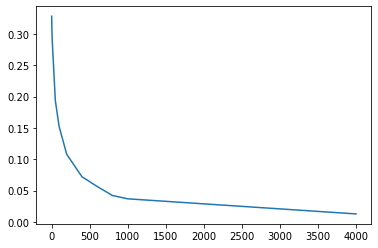

In [9]:
plt.figure()
opti=optimisation_units(10,25,[2,5,10,50,100,200,400,600,800,1000,4000],6,100,0.01,10)
plt.plot([2,5,10,50,100,200,400,600,800,1000,4000],[float(opti[i]) for i in range(len(opti))])
plt.show()

### Comparaison entre les chiffres de MNIST et les chiffres générés par le RBM
On crée une nouvelle classe RBM2 strictement similaire à RBM mais n'utilisant pas de batch. 

In [10]:
class RBM2():
  def __init__(self,n_v, n_h):
    self.a=[0 for i in range(n_v)]
    self.b=[0 for i in range(n_h)]
    self.w=np.random.normal(0,0.1,(n_v,n_h))

  def entree_sortie_RBM(self,V):
     sig=sigmoid(np.dot(V,self.w)+self.b)
     Hs=np.random.binomial(1, sig, size=sig.shape)
     return np.array(sig),Hs
     
  def sortie_entree_RBM(self,H):
     q=sigmoid(np.dot(H,np.transpose(self.w))+self.a)
     Vs=np.random.binomial(1, q, size=q.shape)
     return np.array(q),Vs
  
  def train_RBM(self,X,epochs,learning_rate):
    for j in range(epochs):
      loss=0
      somme=0
      Xs=[]
      for i in range(len(X)):
        Xs.append([ X[i].flatten() ])
      X_size=len(X)
      for i in Xs:
        V=np.array(i)
        p,Hs=RBM.entree_sortie_RBM(self,V)
        q1,V1= RBM.sortie_entree_RBM(self,Hs)
        p1,H1= RBM.entree_sortie_RBM(self,V1)
        dw= (1/X_size)*(np.dot(np.transpose(V),p)-np.dot(np.transpose(V1),p1))
        da= (1/X_size)* np.sum(V-V1,axis=0)
        db= (1/X_size)* np.sum(p-p1,axis=0)
        self.w+=learning_rate*dw
        self.a+=learning_rate*da
        self.b+=learning_rate*db
        loss+=np.mean(np.square(V1-V))
        somme+=1
      print("Epoch " + str(j)+ " Quadratic loss = " + str(loss/somme))
    return str(loss/somme)

Epoch 0 Quadratic loss = 0.22513870615712533
Epoch 1 Quadratic loss = 0.14493773521402592
Epoch 2 Quadratic loss = 0.13298771532601023
Epoch 3 Quadratic loss = 0.12576364878785073
Epoch 4 Quadratic loss = 0.12038496058093359
Epoch 5 Quadratic loss = 0.11602362084263977
Epoch 6 Quadratic loss = 0.11222322512213265
Epoch 7 Quadratic loss = 0.10899652214708944
Epoch 8 Quadratic loss = 0.10613315791084066
Epoch 9 Quadratic loss = 0.10363249497700133
Epoch 10 Quadratic loss = 0.10171699864353555
Epoch 11 Quadratic loss = 0.09962939448643039
Epoch 12 Quadratic loss = 0.09788090648553315
Epoch 13 Quadratic loss = 0.09602851635406774
Epoch 14 Quadratic loss = 0.0945356403430938
Epoch 15 Quadratic loss = 0.09353868983875434
Epoch 16 Quadratic loss = 0.09199545635345606
Epoch 17 Quadratic loss = 0.09105523768727879
Epoch 18 Quadratic loss = 0.09000155534477661
Epoch 19 Quadratic loss = 0.08911041928015578
Epoch 20 Quadratic loss = 0.08796813328029861
Epoch 21 Quadratic loss = 0.08731539842323716

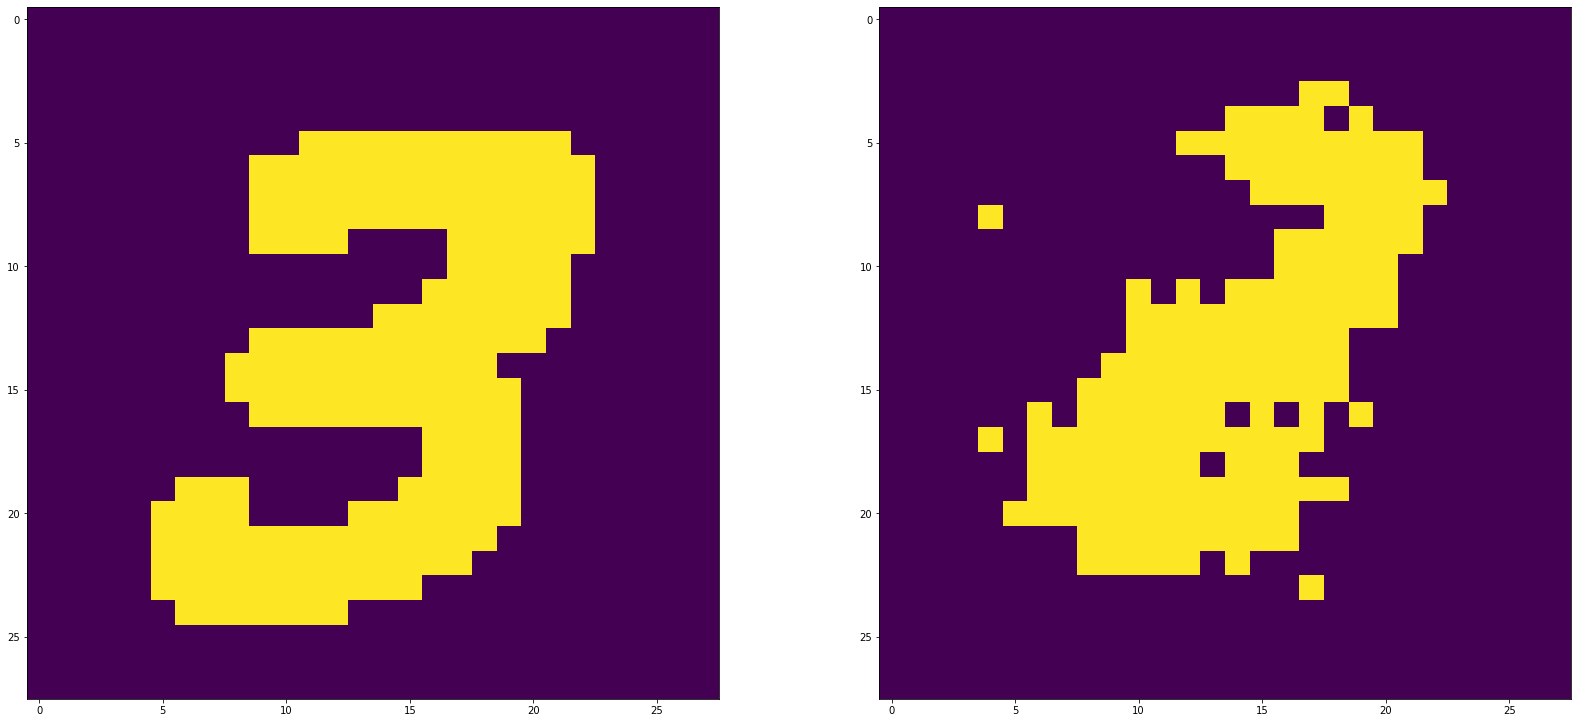

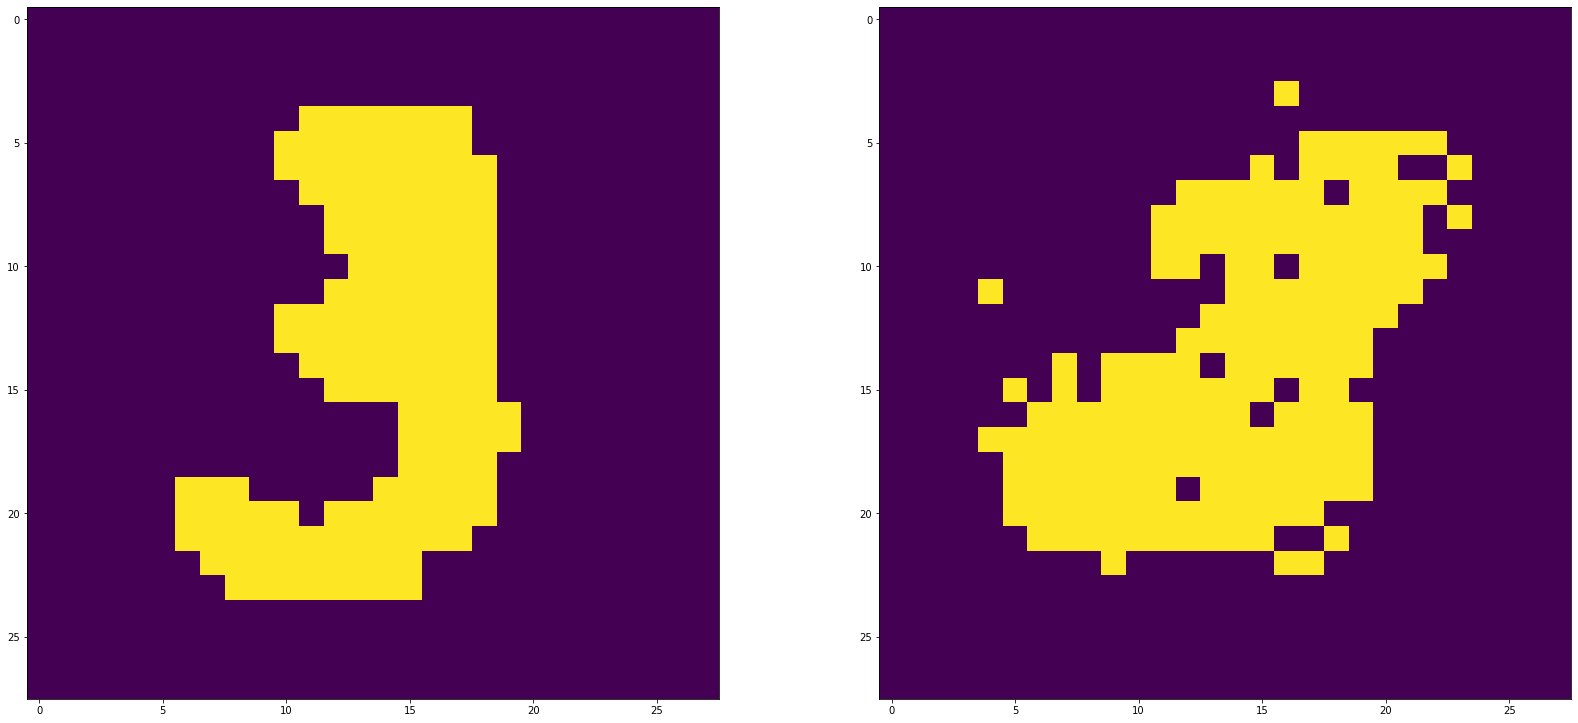

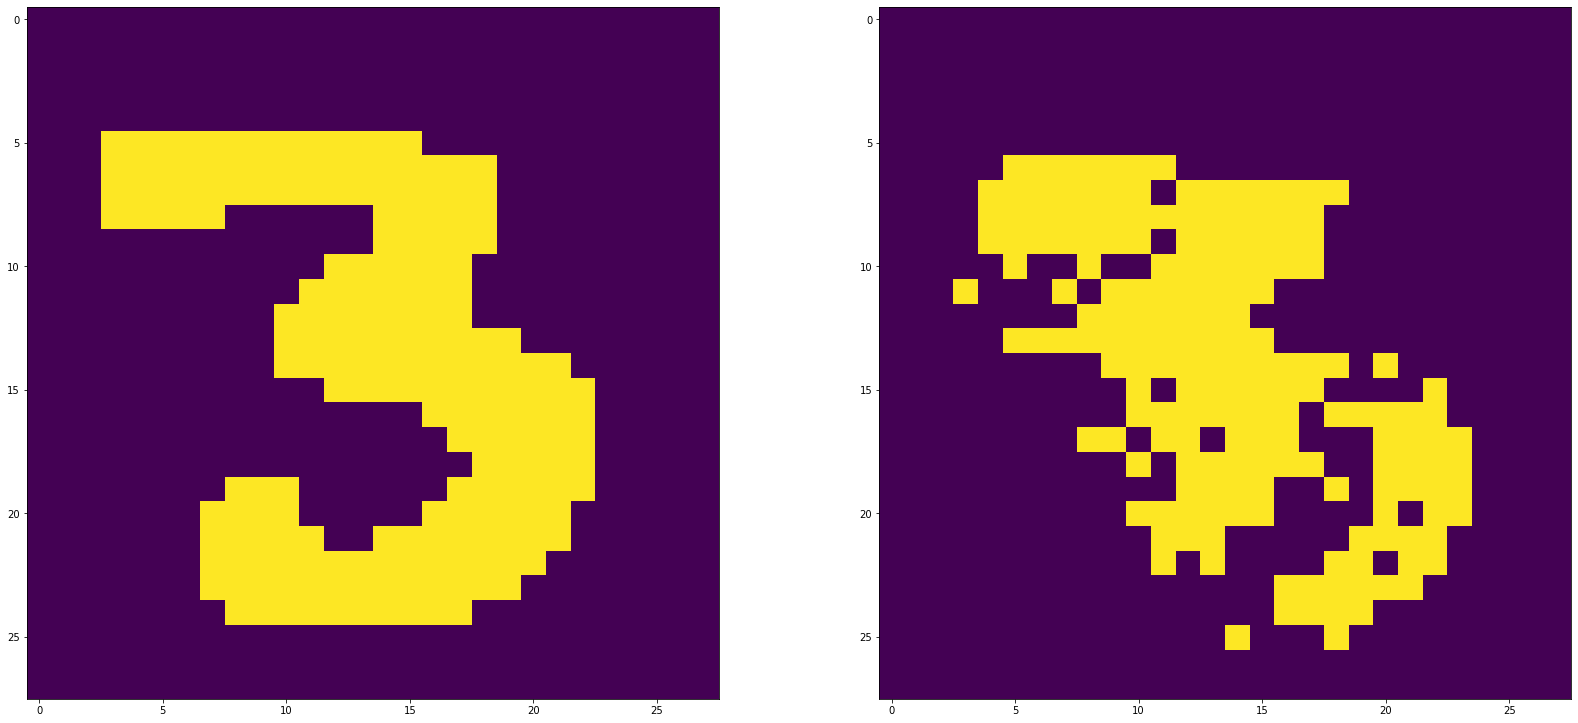

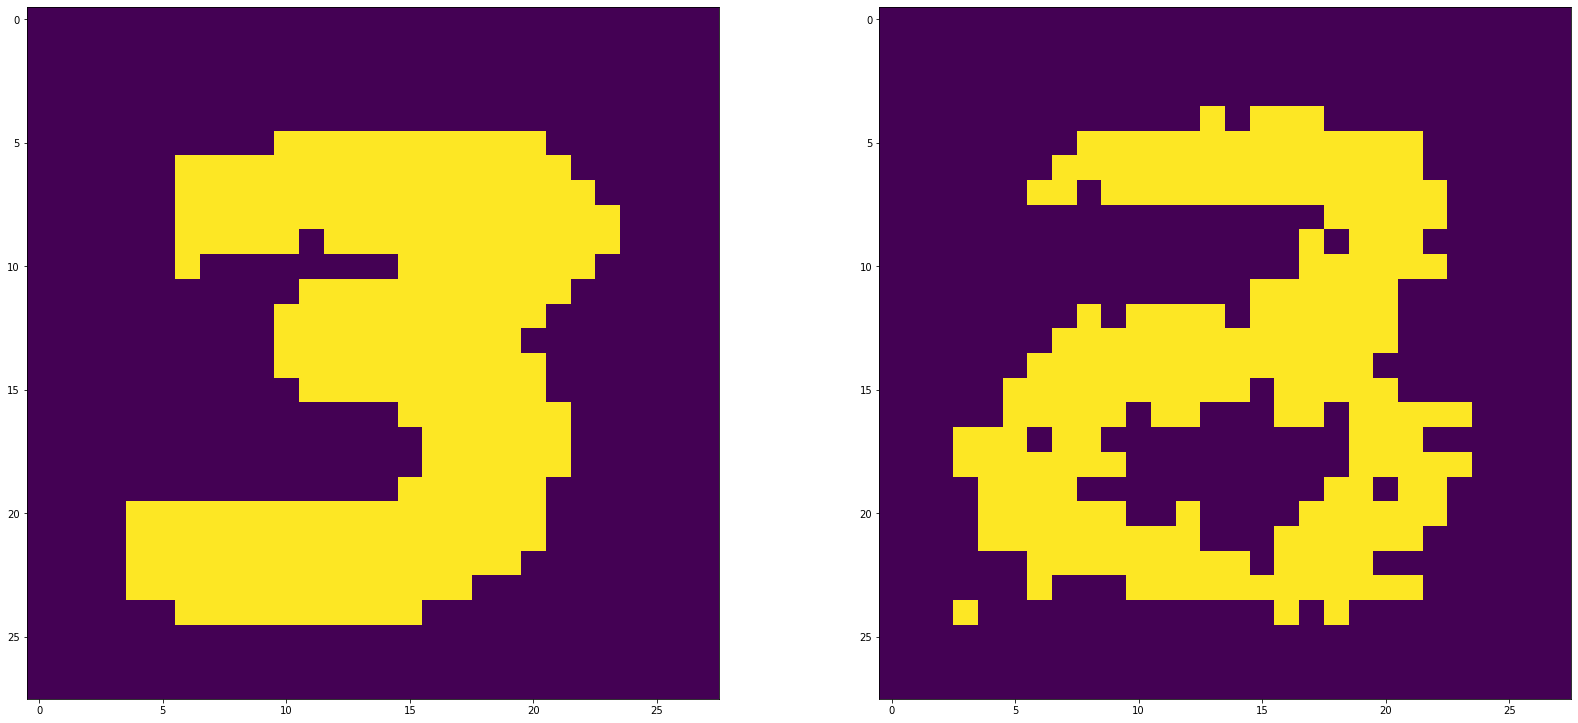

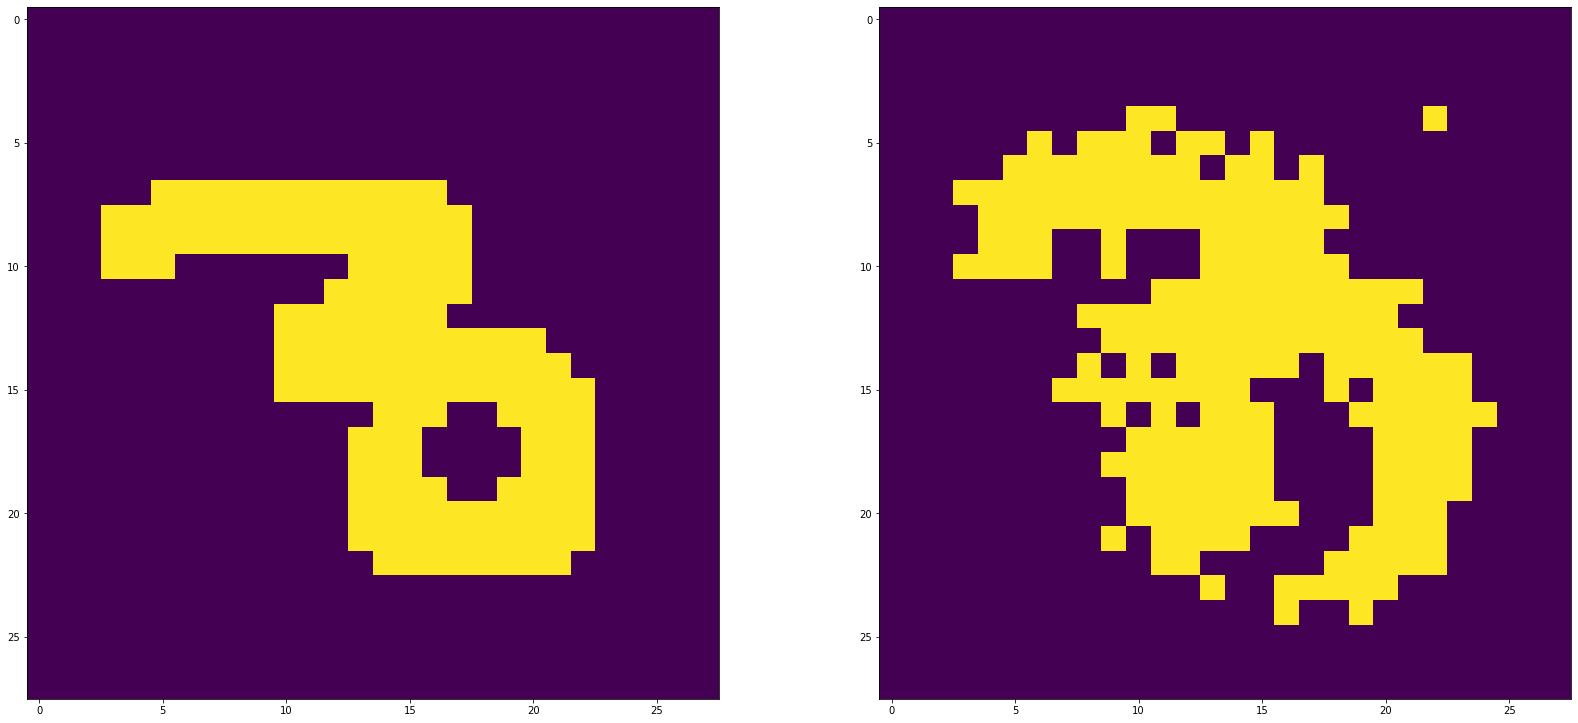

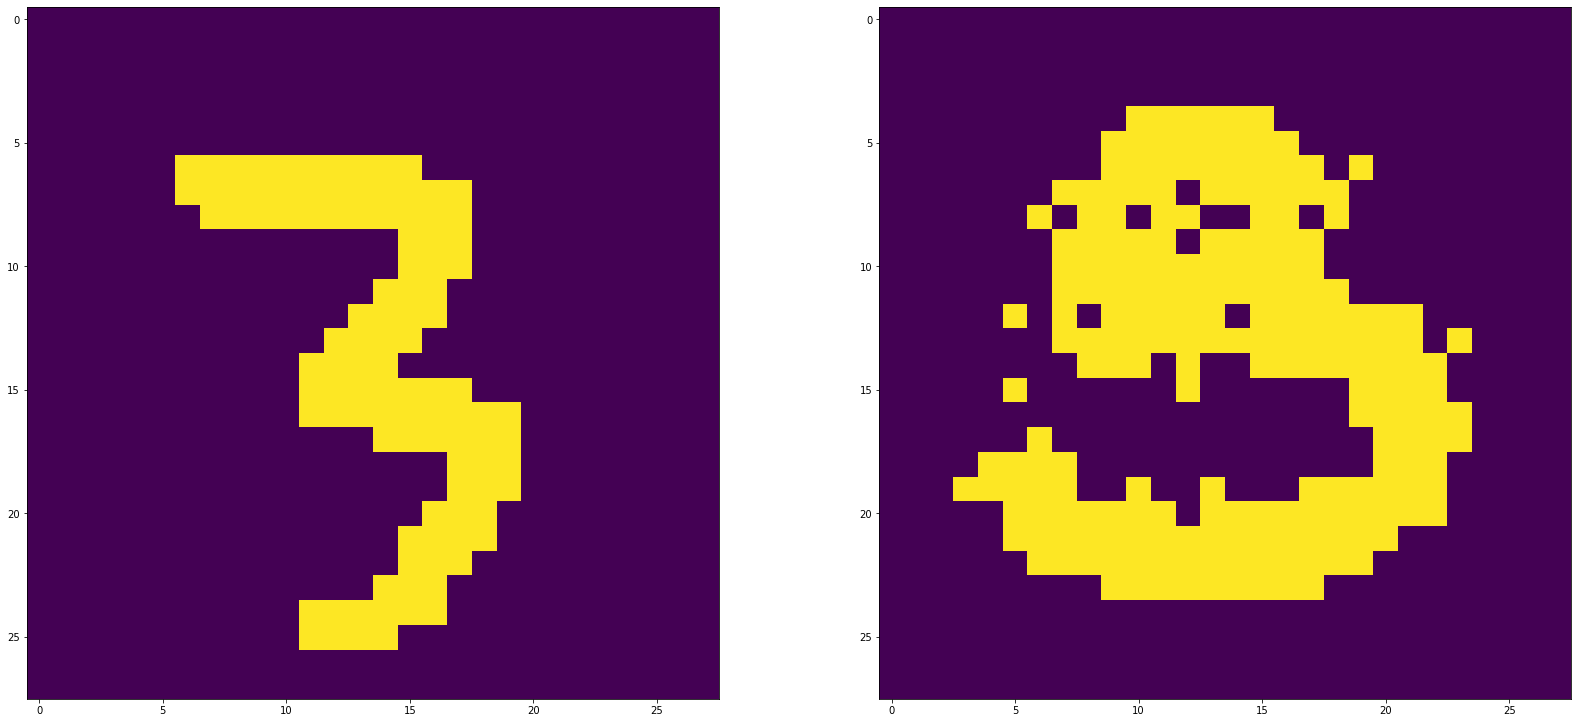

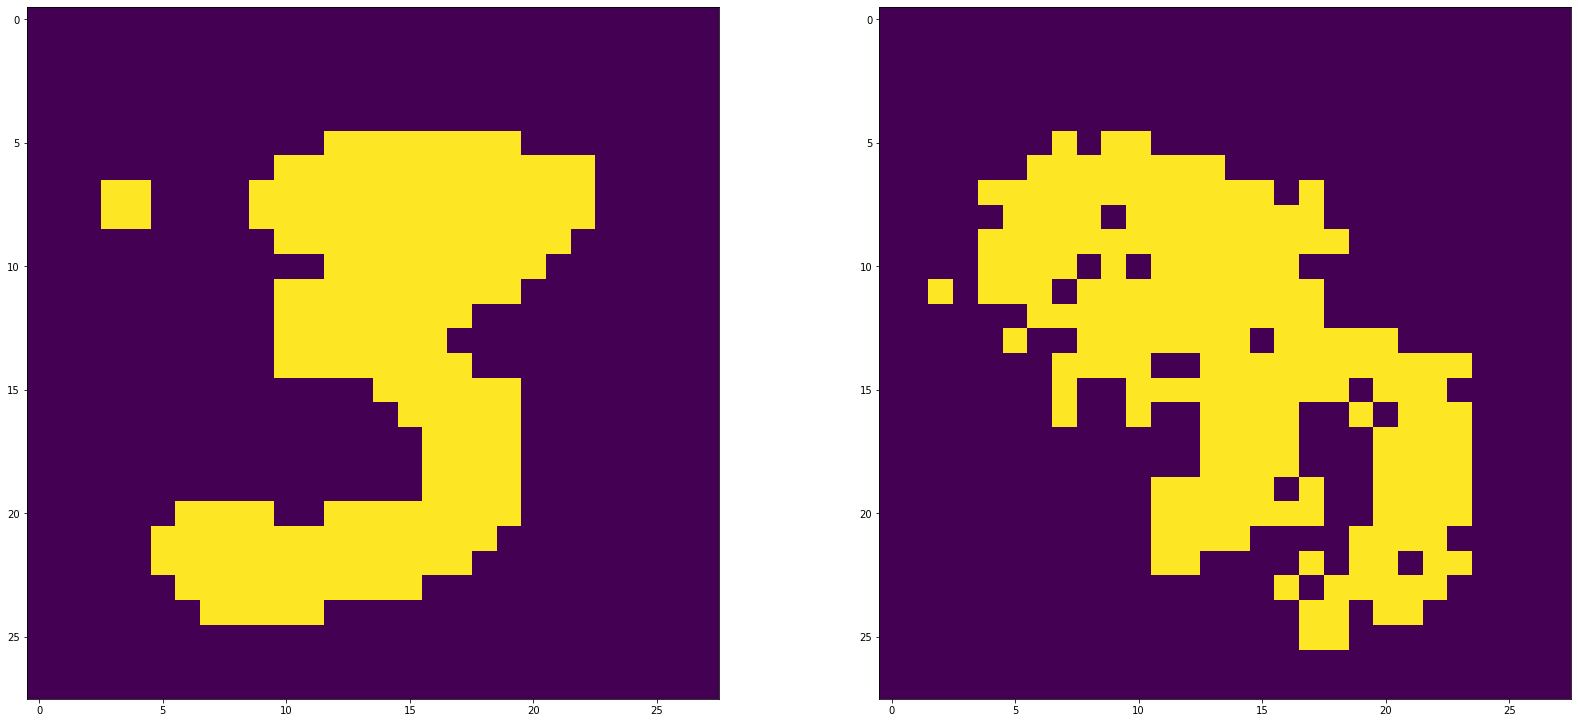

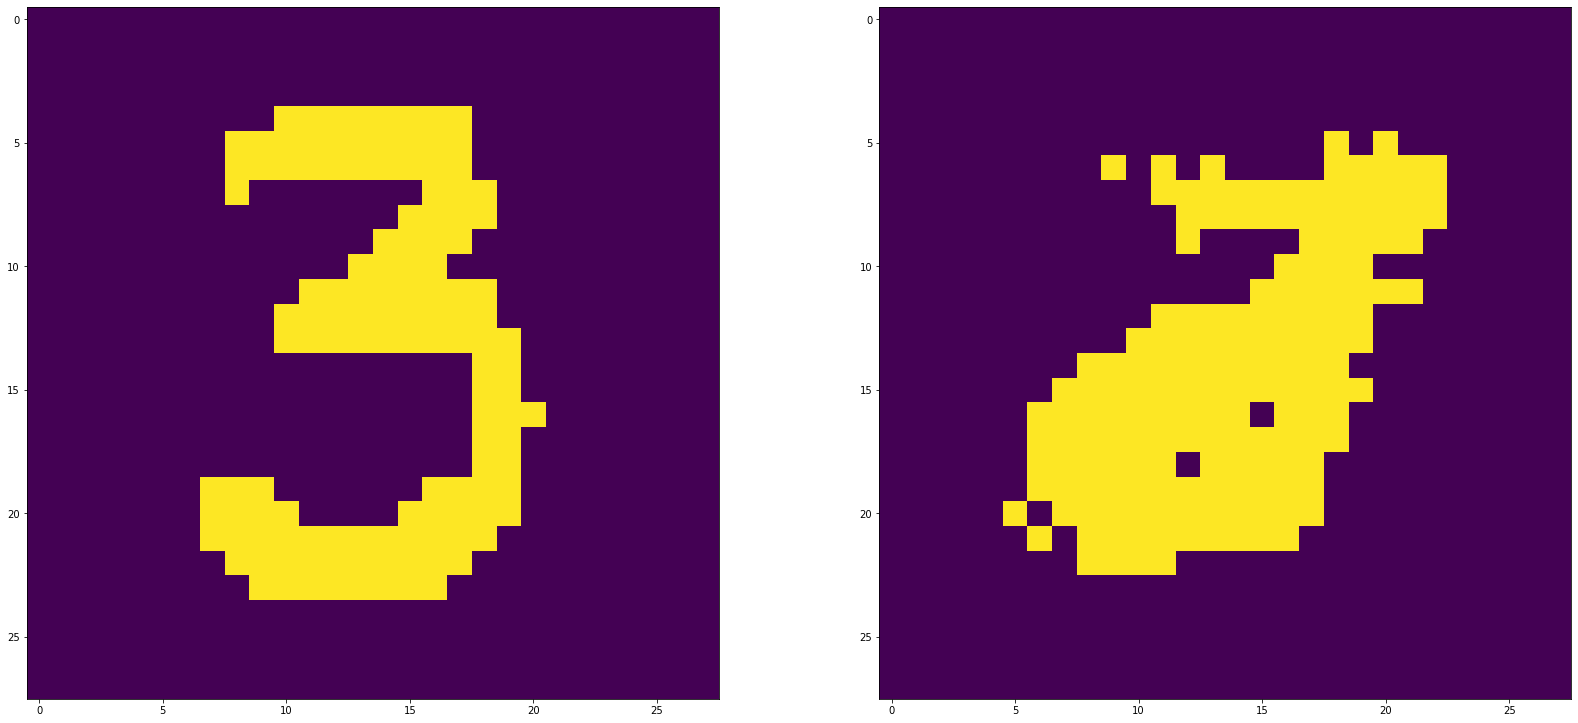

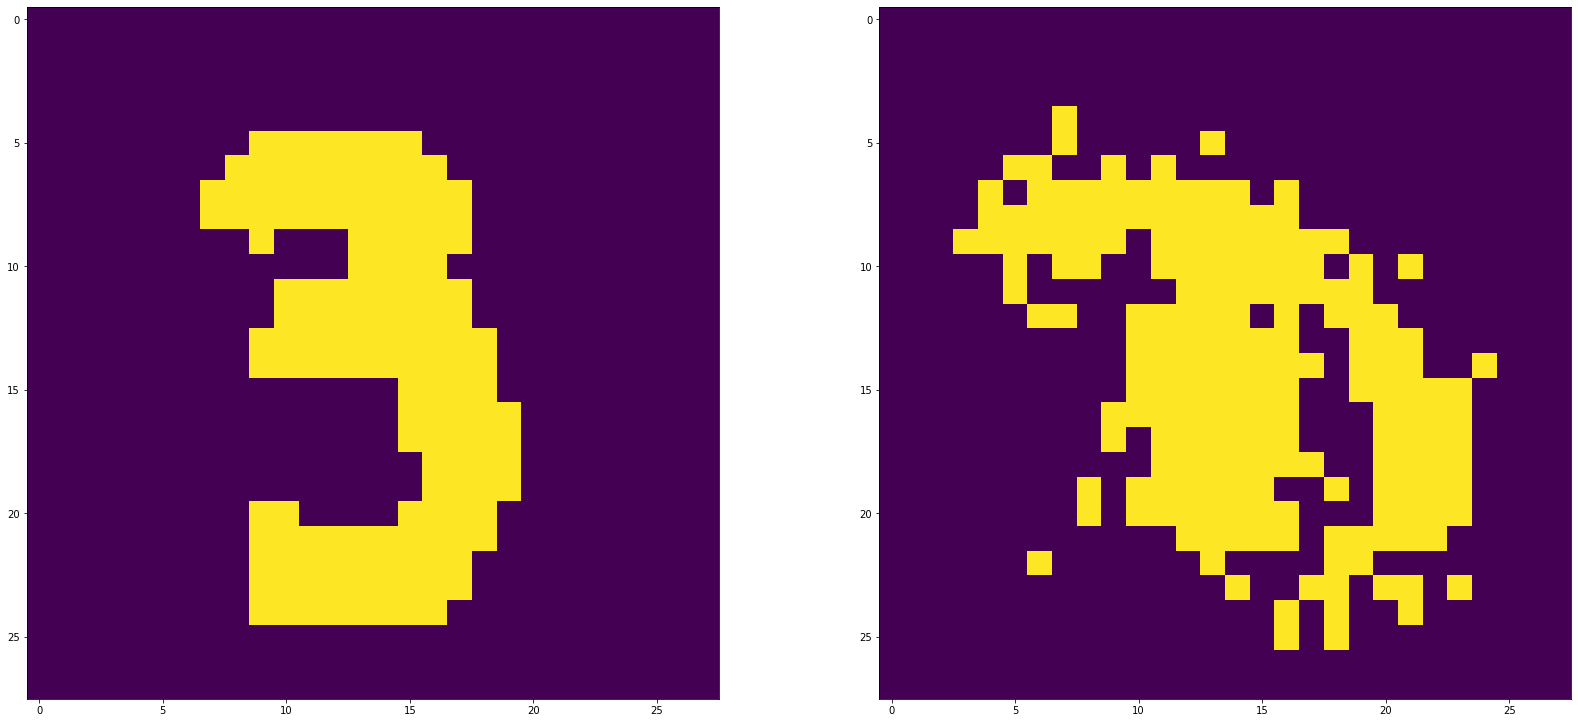

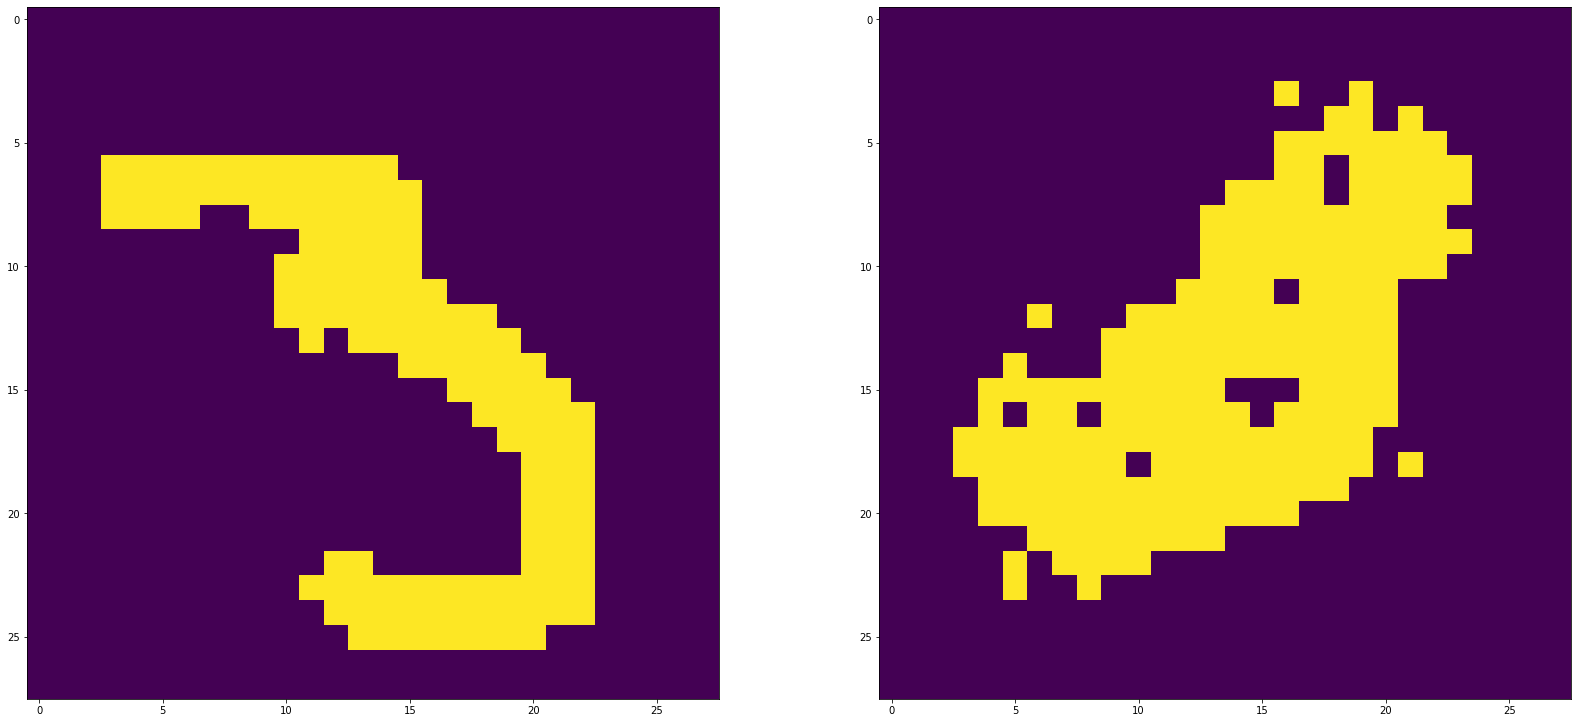

In [36]:
def pre_process_MNIST(X):
  '''
  Prend en argument une image de la base de données MNIST 28x28 
  et renvoie cette image en binaire (pixel=0 ou pixel=1)
  '''
  Y=[[0 for i in range(len(X))]for j in range(len(X[0]))]
  for i in range(len(X)):
    for j in range(len(X[0])):
      if X[i][j] !=0:
        Y[i][j]=1
      else:
        Y[i][j]=0
  npy=np.array(Y)
  #plt.figure()
  #plt.imshow(npy.reshape(len(Y),len(Y[i])))
  return Y

def generer_image_RBM2(X,n_images,rbm,epochs,learning_rate,iter_gibbs):
  rbm.train_RBM(X,epochs,learning_rate)
  L,l=np.shape(X[0])
  for i in range(n_images):
    v=np.random.randint(2,size=L*l)
    for k in range(iter_gibbs):
      ph,h=rbm.entree_sortie_RBM(v)
      pv,v=rbm.sortie_entree_RBM(h)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(L,l))
    plt.subplot(221)
    plt.imshow(np.array(X[i]).reshape(L,l))

    plt.subplot(222)
    plt.imshow(np.array(v).reshape((L,l)))
    plt.show()

def resultats_RBM_for_MNIST(n_images,digit,n_entrainement,arc,epochs,learning_rate,iter_gibbs):
  '''
  Prend en argument le nombre d'images à générer, le chiffre que l'on veut génerer, 
  le nombre de données d'entraînement, le nombre d'unités cachées,
  le nombre d'epochs, le learning rate et le nombre d'itérations de Gibbs
  Renvoie les images générées comparées à des images de la base de données d'entraînement et les résultats de l'entraînement
  '''
  X=np.concatenate([ [pre_process_MNIST(digits(digit)[i])] for i in range(n_entrainement+1)])
  L,l=np.shape(X[0])
  rbm=RBM2(L*l,arc)
  final_loss=rbm.train_RBM(X,epochs,learning_rate)
  generer_image_RBM2(X,n_images,rbm,epochs,learning_rate,iter_gibbs)

resultats_RBM_for_MNIST(10,3,2000,800,100,0.1,100)

### Génération de chiffres MNIST par GAN
On utilise maintenant une architecture GAN pour générer les chiffres de la base de données MNIST. 

###Base de données

In [12]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 0
batch_size = 64

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



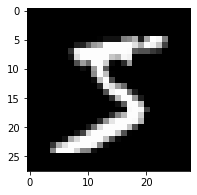

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Architecture du disciriminator et du generator

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)

        return out

In [15]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))

        return out

### Définition des classes

In [16]:
# Discriminator
input_size = 784 #taille de l'image d'entrée
d_output_size = 1 #taille du discriminateur en sortie
d_hidden_size = 32 # taille de la dernière couches


# Generator
z_size = 100 # taille du vecteur latent
g_output_size = 784 # taille du discriminator en sortie
g_hidden_size = 32 # taille de la première couche cachée

In [17]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

### Définition des fonctions de pertes

In [18]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [19]:
import torch.optim as optim

lr = 0.002
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

### Entraînement

In [20]:
import pickle as pkl

num_epochs = 100

samples = []
losses = []

print_every = 400

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)

        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        d_optimizer.zero_grad()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
              
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    

    losses.append((d_loss.item(), g_loss.item()))
    
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3814 | g_loss: 0.7318
Epoch [    1/  100] | d_loss: 0.8249 | g_loss: 3.6938
Epoch [    1/  100] | d_loss: 1.5824 | g_loss: 1.0054
Epoch [    2/  100] | d_loss: 1.3599 | g_loss: 0.8299
Epoch [    2/  100] | d_loss: 1.3243 | g_loss: 0.6379
Epoch [    2/  100] | d_loss: 0.9680 | g_loss: 2.1242
Epoch [    3/  100] | d_loss: 0.9190 | g_loss: 1.6799
Epoch [    3/  100] | d_loss: 0.9858 | g_loss: 1.2931
Epoch [    3/  100] | d_loss: 1.2030 | g_loss: 0.9627
Epoch [    4/  100] | d_loss: 1.1107 | g_loss: 0.9947
Epoch [    4/  100] | d_loss: 1.2792 | g_loss: 1.2572
Epoch [    4/  100] | d_loss: 1.1135 | g_loss: 1.2416
Epoch [    5/  100] | d_loss: 1.3307 | g_loss: 0.8200
Epoch [    5/  100] | d_loss: 1.0904 | g_loss: 1.1886
Epoch [    5/  100] | d_loss: 1.4549 | g_loss: 0.9557
Epoch [    6/  100] | d_loss: 1.3538 | g_loss: 1.1466
Epoch [    6/  100] | d_loss: 1.2202 | g_loss: 0.8846


KeyboardInterrupt: ignored

### Résultats de l'entraînement

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Affichage d'images générées

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
view_samples(-1, samples)